In [135]:
import tensorflow as tf
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam

Load and Fix the Dataset

In [136]:
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

In [137]:
print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)



Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


In [138]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : 9')

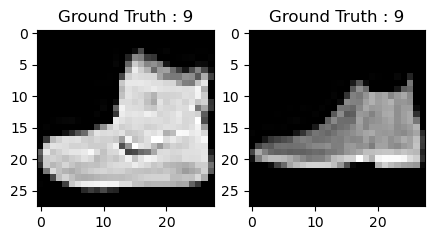

In [139]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

Preprocess the Data

In [140]:
train_X = train_X.reshape(-1, 28,28, 1) #set each image to size of matrix 28*28*1
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [141]:
#data is in integer 8 format, need to convert to float32
#rescale the pixel values to only be in range 0-1
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255. #normalise pixel values to be range 0-1
test_X = test_X / 255.

In [142]:
#convert the categories into a vector of numbers
#machine learning algorithms cant work with this data directly
#generate one boolean column for each category
#row vector 1*10, 10 categories

# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [143]:
#split training data 
#random parameter, ensures a random split generated each time the code is run
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [144]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

Model : Convolution, Pooling and Fully Connected Layer

In [145]:
batch_size = 64  #number of samples during training
epochs = 20 # number of times training is done
num_classes = 10 #number of classes in the dataset (we have 10 categories therefore 10)

In [146]:
fashion_model = Sequential()

#add the first convulutional layer
#kernel 3*3, linear activation function, 32 filters
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
#uses leaky relu, interesting, with learning rate 0.1
fashion_model.add(LeakyReLU(alpha=0.1))
#pooling layer, 2*2 matrix, max values
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
#add dropout to the model, firstly it is set to 0.25, drops some neurons to not use during training
fashion_model.add(Dropout(0.25))

#add the second convulutional layer
#64 layers, 3*3, linear function
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))

#add the 3rd convulutional layer
#128 layers, 3*3 matrix, linear
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#increase neurons dropped
fashion_model.add(Dropout(0.4))

#flatten the vector for the fcl
fashion_model.add(Flatten())
#dense layer (fully-connected), uses linear, 128 layers
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))   
fashion_model.add(Dropout(0.3))

#dense final layer, uses number of classes, in this case 10
#uses softmax function to determine the probabilities
fashion_model.add(Dense(num_classes, activation='softmax'))

#common loss function used, dam optmizer, adapts learning rate during training
fashion_model.compile(loss=categorical_crossentropy, optimizer=Adam(),metrics=['accuracy', Precision(), Recall(), AUC()])

In [147]:
fashion_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                     

Train the Model

In [ ]:
#uses fit method, trains the model on the train x and train label data
#returns a History object, this contains the information such as loss and accuracy which we can graph
#batch size specifies the number of samples per gradient update
#epoch is the number of times the test is done
#validation data specifies the data on which to evaluate the loss and any model metrics at the end of each epoch
#evaluates the data against the valid data
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 26s 33ms/step - loss: 0.6137 - accuracy: 0.7731 - precision_1: 0.8526 - recall_1: 0.7040 - auc_1: 0.9781 - val_loss: 0.3751 - val_accuracy: 0.8600 - val_precision_1: 0.8875 - val_recall_1: 0.8314 - val_auc_1: 0.9905
Epoch 2/20
264/750 [=========>....................] - ETA: 14s - loss: 0.4044 - accuracy: 0.8541 - precision_1: 0.8856 - recall_1: 0.8202 - auc_1: 0.9895

In [117]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.4848746657371521
Test accuracy: 0.9146000146865845


Graph Results for Evaluation

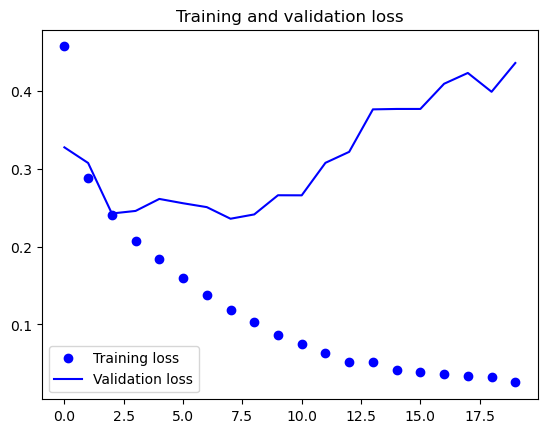

In [119]:
#Graph the accuracy and the loss
accuracy = fashion_train.history['accuracy']
val_accuracy = fashion_train.history['val_accuracy']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
fashion_model.save("fashion_model_dropout.h5py")